# Analysis of Beam Simulator Images and Brighter-fatter Correction
<br>Owner(s): **Andrew Bradshaw** ([@andrewkbradshaw](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@andrewkbradshaw))
<br>Last Verified to Run: **2021-04-01**
<br>Verified Stack Release: **21.0.0**

This notebook demonstrates the [brighter-fatter systematic error](https://arxiv.org/abs/1402.0725) on images of stars and galaxies illuminated on an ITL-3800C-002 CCD at the [UC Davis LSST beam simulator laboratory](https://arxiv.org/abs/1411.5667). Using a series of images at increasing exposure times, we demonstrate the broadening of image profiles on DM stack shape measurements, and a [possible correction method](https://arxiv.org/abs/1711.06273) which iteratively applies a kernel to restore electrons to the pixels from which they were deflected. To keep things simple, for now we skip most DM stack instrument signature removal (ISR) and work on a subset of images which are already processed arrays (500x500) of electrons.

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Characterize and measure objects (stars/galaxies) in LSST beam simulator images
2. Test the Brighter-Fatter kernel correction method on those images
3. Build your own tests of stack ISR algorithms

### Logistics
This notebook is intended to be runnable on `lsst-lsp-stable.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Set-up

In [1]:
# What version of the Stack are we using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-kadrlica-r21-0-0
lsst_distrib          21.0.0+973e4c9e85 	current v21_0_0 setup


In [2]:
%pwd

'/home/kadrlica/notebooks/.beavis/StackClub/ImageProcessing'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from itertools import cycle
from astropy.io import fits
import time,glob,os


# if running stack v16.0, silence a long matplotlib Agg warning with:
#import warnings
#warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s lsst_distrib

# make a directory to write the catalogs
username=os.environ.get('USERNAME')
cat_dir='/home/'+username+'/DATA/beamsim/'
if not os.path.exists(cat_dir):
    ! mkdir /home/$USER/DATA/beamsim/

nb-kadrlica-r21-0-0
   21.0.0+973e4c9e85 	current v21_0_0 setup


## Step 1: Read in an image
Cut-outs of beam simulator star/galaxy images have been placed in the shared data directory at `/project/shared/data/beamsim/bfcorr/`. We skip (for now) most of the instrument signature removal (ISR) steps because these are preprocessed images (bias subtracted, gain corrected). We instead start by reading in one of those `.fits` files and making an image plane `afwImage.ExposureF` as well as a variance plane (based upon the image), which is then ready for characterization and calibration in the following cells.

In [4]:
import lsst.afw.image as afwImage
from lsst.ip.isr.isrFunctions import updateVariance

# where the data lives, choosing one image to start
imnum=0 # for this dataset, choose 0-19 as an example
fitsglob='/project/shared/data/beamsim/bfcorr/*part.fits'
fitsfilename = np.sort(glob.glob(fitsglob))[imnum]  
#fitsfilename ='/home/sarujin/testdata/ITL-3800C-002_spot_spot_400_20171108114719whole.fits'
# Read in a single image to an afwImage.ImageF object
image_array=afwImage.ImageF.readFits(fitsfilename)
image = afwImage.ImageF(image_array)
exposure = afwImage.ExposureF(image.getBBox())
exposure.setImage(image)
hdr=fits.getheader(fitsfilename) # the header has some useful info in it
print("Read in ",fitsfilename.split('/')[-1])

# Set the variance plane using the image plane via updateVariance function
gain = 1.0 # because these images are already gain corrected
readNoise = 10.0  # in electrons
updateVariance(exposure.maskedImage, gain, readNoise)

# Another way of setting variance and/or masks?
#mask = afwImage.makeMaskFromArray(np.zeros((4000,4072)).astype('int32'))
#variance = afwImage.makeImageFromArray((readNoise**2 + image_array.array())
#masked_image = afwImage.MaskedImageF(image, mask, variance)
#exposure = afwImage.ExposureF(masked_image)

Read in  ITL-3800C-002_spot_spot_400_20171108114719part.fits


Now visualize the image and its electron distribution using matplotlib. Things to note: 1) the array is (purposefully) tilted with respect to the pixel grid, 2) most pixel values are at the background/sky level (a function of the mask opacity and illumination), but there is a pileup of counts around ~200k electrons indicating full well and saturation in some of the brightest pixels of the image

(Text(0.5, 0, 'Number of electrons in pixel'),
 Text(0, 0.5, 'Number of pixels'))

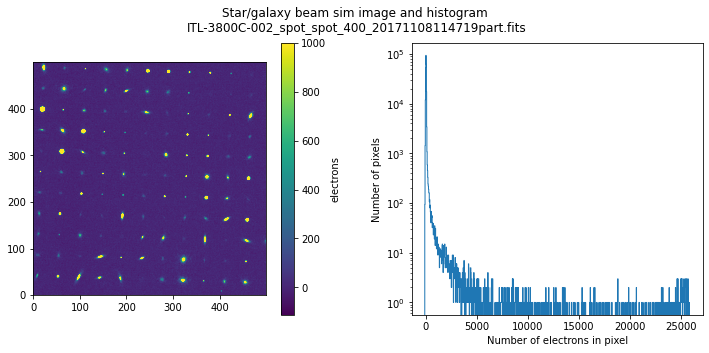

In [5]:
plt.figure(figsize=(12,5)),plt.subplots_adjust(wspace=.3)
plt.suptitle('Star/galaxy beam sim image and histogram \n'+fitsfilename.split('/')[-1])

plt.subplot(121)
plt.imshow(exposure.image.array,vmax=1e3,origin='lower')
plt.colorbar(label='electrons')

plt.subplot(122)
plt.hist(exposure.image.array.flatten(),bins=1000,histtype='step')
plt.yscale('log')#,plt.xscale('log')
plt.xlabel('Number of electrons in pixel'),plt.ylabel('Number of pixels')

## Step 2: Perform image characterization and initial measurement
We now perform a base-level characterization of the image using the stack. We set some configuration settings which are specific to our sestup which has a very small optical PSF, setting a PSF size and turning off some other aspects such as cosmic ray rejection because of this.

In [6]:
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
import lsst.meas.extensions.shapeHSM

# first set a few configs that are specific to our beam simulator data
charConfig = CharacterizeImageConfig()
#this set the fwhm of the simple PSF to that of optics
charConfig.installSimplePsf.fwhm = .5
charConfig.doMeasurePsf = False
charConfig.doApCorr = False # necessary
charConfig.repair.doCosmicRay = False  
# we do have some cosmic rays, but we also have subpixel mask features and an undersampled PSF
charConfig.detection.background.binSize = 10   # worth playing around with
#charConfig.background.binSize = 50
charConfig.detection.minPixels = 5   # also worth playing around with

# Add the HSM (Hirata/Seljak/Mandelbaum) adaptive moments shape measurement plugin
charConfig.measurement.plugins.names |= ["ext_shapeHSM_HsmSourceMoments"]
# to configure hsm you would do something like
# charConfig.measurement.plugins["ext_shapeHSM_hsmSourceMoments"].addFlux = True
# (see sfm.py in meas_base for all the configuration options for the measurement task)

charTask = CharacterizeImageTask(config=charConfig)

charTask.run?
# use charTask.run instead of characterize for v16.0+22
# could also perform similar functions with processCcdTask.run()

In [7]:
# Display which plugins are being used for measurement
charConfig.measurement.plugins.active 

[lsst.meas.base.gaussianFlux.GaussianFluxConfig(doMeasure=True, background=0.0),
 lsst.meas.base.sdssCentroid.SdssCentroidConfig(doMeasure=True, binmax=16, doFootprintCheck=True, maxDistToPeak=-1.0, peakMin=-1.0, wfac=1.5),
 lsst.meas.base.psfFlux.PsfFluxConfig(doMeasure=True, badMaskPlanes=[]),
 lsst.meas.base.apertureFlux.ApertureFluxConfig(doMeasure=True, maxSincRadius=10.0, radii=[3.0, 4.5, 6.0, 9.0, 12.0, 17.0, 25.0, 35.0, 50.0, 70.0], shiftKernel='lanczos5'),
 lsst.meas.base.sdssShape.SdssShapeConfig(doMeasure=True, background=0.0, doMeasurePsf=True, maxIter=100, maxShift=0.0, tol1=9.999999747378752e-06, tol2=9.999999747378752e-05),
 lsst.meas.base.pixelFlags.PixelFlagsConfig(doMeasure=True, masksFpAnywhere=[], masksFpCenter=[]),
 lsst.meas.extensions.shapeHSM.hsmMomentsControl.HsmSourceMomentsConfig(doMeasure=True)]

Characterization took  0.27  seconds
Detected  65  objects 


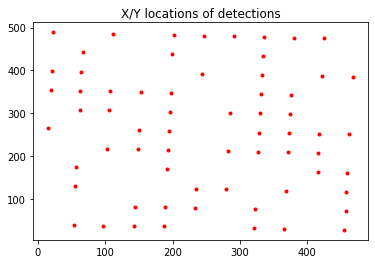

In [8]:
tstart=time.time()
charResult = charTask.run(exposure) # charTask.run(exposure) stack v16.0+22
print("Characterization took ",str(time.time()-tstart)[:4]," seconds")
print("Detected ",len(charResult.sourceCat)," objects ")

plt.title('X/Y locations of detections')
plt.plot(charResult.sourceCat['base_SdssCentroid_x'],charResult.sourceCat['base_SdssCentroid_y'],'r.')

This figure illustrates the centroids of detections made during characterization. Note that not all objects have been detected in this first round.

In [9]:
# display some of the source catalog measurements filtered by searchword
searchword='flux'
for name in charResult.sourceCat.schema.getOrderedNames():
    if searchword in name.lower():
        print(name)

base_SdssShape_instFlux
base_SdssShape_instFluxErr
base_SdssShape_instFlux_xx_Cov
base_SdssShape_instFlux_yy_Cov
base_SdssShape_instFlux_xy_Cov
base_CircularApertureFlux_3_0_instFlux
base_CircularApertureFlux_3_0_instFluxErr
base_CircularApertureFlux_3_0_flag
base_CircularApertureFlux_3_0_flag_apertureTruncated
base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated
base_CircularApertureFlux_4_5_instFlux
base_CircularApertureFlux_4_5_instFluxErr
base_CircularApertureFlux_4_5_flag
base_CircularApertureFlux_4_5_flag_apertureTruncated
base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated
base_CircularApertureFlux_6_0_instFlux
base_CircularApertureFlux_6_0_instFluxErr
base_CircularApertureFlux_6_0_flag
base_CircularApertureFlux_6_0_flag_apertureTruncated
base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated
base_CircularApertureFlux_9_0_instFlux
base_CircularApertureFlux_9_0_instFluxErr
base_CircularApertureFlux_9_0_flag
base_CircularApertureFlux_9_0_flag_apertureTruncated
base_CircularAp

Unique mask plane values:  [ 0 32]
Mask dictionary entries:  {'BAD': 0, 'CR': 3, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INTRP': 2, 'NO_DATA': 8, 'SAT': 1, 'SUSPECT': 7}


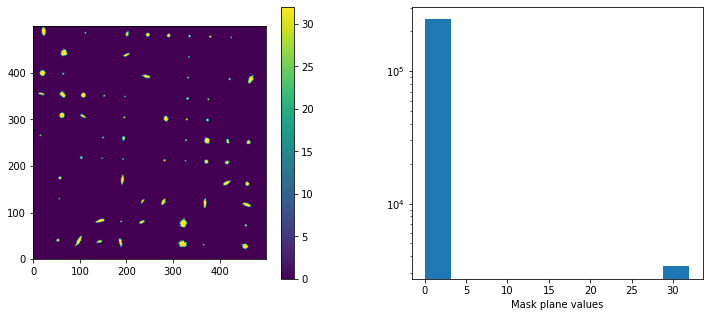

In [10]:
# Looking at the mask plane, which started off as all zeros
# and now has some values of 2^5
maskfoo=exposure.mask
print("Unique mask plane values: ",np.unique(maskfoo.array))
print("Mask dictionary entries: ",maskfoo.getMaskPlaneDict())

plt.figure(figsize=(12,5)),plt.subplots_adjust(wspace=.3)
plt.subplot(121)
plt.imshow(maskfoo.array,origin='lower'),plt.colorbar()
plt.subplot(122)
plt.hist(maskfoo.array.flatten()),plt.xlabel('Mask plane values')
plt.yscale('log')

The above figures illustrate the new mask plane of the exposure object which was added and modified during characterization. Values of 0 and 5 are now seen, which correspond to unassociated pixels and those which are "detected".

## Step 3: Further image calibration and measurement
This builds on the exposure output from characterization, using the new mask plane as well as the source catalog. Similar to the characterization, we turn off some processing which is suited to our particular setup. For this dataset a calibrate task is almost unncessary (as it is not on-sky data and we don't have a reference catalog), however, it does provide a background-subtracted image and for completeness it is included here. The steps in calibration that are turned on/off can be seen by printing the calibration config object.

In [11]:
from lsst.pipe.tasks.calibrate import CalibrateTask, CalibrateConfig

calConfig = CalibrateConfig()
calConfig.doAstrometry = False
calConfig.doPhotoCal = False
calConfig.doApCorr = False
calConfig.doDeblend = False   # these are well-separated objects, deblending adds time & trouble
# these images should have a uniform background, so measure it
#  on scales which are larger than the objects
calConfig.detection.background.binSize = 50
calConfig.detection.minPixels = 5
calConfig.measurement.plugins.names |= ["ext_shapeHSM_HsmSourceMoments"]
# to configure hsm you would do something like
#charConfig.measurement.plugins["ext_shapeHSM_hsmSourceMoments"].addFlux = True

calTask = CalibrateTask(config= calConfig, icSourceSchema=charResult.sourceCat.schema)

#calTask.run? # for stack v16.0+22 
calTask.run?

In [12]:
tstart=time.time()
# for stack v16.0+22, change to calTask.run(charResult.exposure)
calResult = calTask.run(charResult.exposure, background=charResult.background,
                              icSourceCat = charResult.sourceCat)

print("Calibration took ",str(time.time()-tstart)[:4]," seconds")
print("Detected ",len(calResult.sourceCat)," objects ")

Calibration took  0.35  seconds
Detected  200  objects 


Below we look at some of the measurements in the source catalog which has been attached to the calibration result. We also save the source catalog to `$fitsfilename.cat` in `/home/$USER/beamsim/`, which was created in the first cell. This will allow the results from each image to be read in after these measurements are performed on each image.

In [13]:
print("Catalogs will be saved to: "+cat_dir)

Catalogs will be saved to: /home/kadrlica/DATA/beamsim/


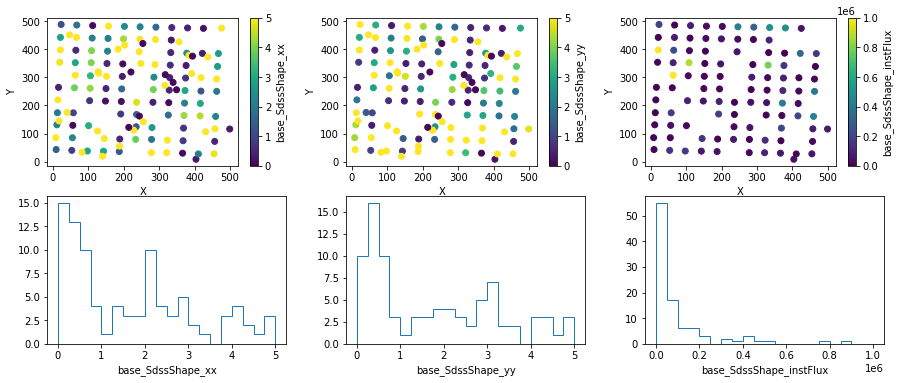

In [14]:
src=calResult.sourceCat  #.copy(deep=True) ?
#print(src.asAstropy)

# catalog directory
src.writeFits(cat_dir+fitsfilename.split('/')[-1].replace('.fits','.cat'))
# read back in and access via:
#catalog=fits.open(fitsfilename+'.cat')
#catalog[1].data['base_SdssShape_xx'] etc.

par_names=['base_SdssShape_xx','base_SdssShape_yy','base_SdssShape_instFlux']
par_mins=[0,0,0]
par_maxs=[5,5,1e6]
n_par=len(par_names)


plt.figure(figsize=(5*n_par,6)),plt.subplots_adjust(wspace=.25)
for par_name,par_min,par_max,i in zip(par_names,par_mins,par_maxs,range(n_par)):
    plt.subplot(2,n_par,i+1)
    plt.scatter(src['base_SdssCentroid_x'],src['base_SdssCentroid_y'],c=src[par_name],marker='o',vmin=par_min,vmax=par_max)
    plt.xlabel('X'),plt.ylabel('Y'),plt.colorbar(label=par_name)


    plt.subplot(2,n_par,n_par+i+1)
    plt.hist(src[par_name],range=[par_min,par_max],bins=20,histtype='step')
    plt.xlabel(par_name)

The above figures show the 2-dimensional distribution of detected objects measured parameter values  and their histogram. By default, two shape parameters (in pixels) and a flux measurement (in electrons) are shown, but this can be modified through the `par_names` variable in the cell above. 

## Step 4: Apply the brighter-fatter kernel correction to an image
This brighter fatter correction method takes in a "kernel" (derived from theory or flat fields) which models the broadening of incident image profiles assuming the pixel boundary displacement can be represented as the gradient of a scalar field. Given a kernel and this assumption, the incident image profile can in theory be reconstructed using an iterative process, which we test here using our beam simulator images. See [this paper](https://arxiv.org/abs/1711.06273) and the IsrTask docstring below for more details about the theory and its assumptions. The kernel used here is not generated by the stack but rather through similar code which was written at UC Davis by Craig Lage. Future additions to the notebook will use a stack-generated kernel when available.

In [15]:
#from lsst.ip.isr.isrTask import IsrTask # brighterFatterCorrection lives here
#isr=IsrTask()
import lsst.ip.isr as isr

pre_bfcorr_exposure=exposure.clone() #save a copy of the pre-bf corrected image

isr.brighterFatterCorrection?

Brighter-fatter correction took 0.2975161075592041  seconds
-0.04  percent change in flux


Text(0.5, 0, 'Pixel values [e-]')

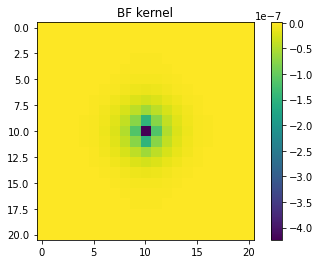

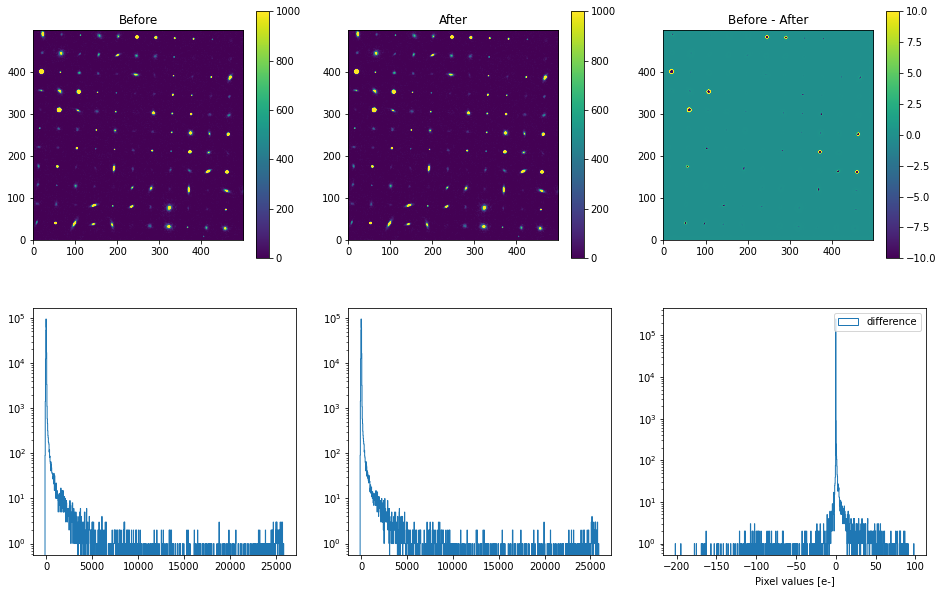

In [16]:
# Read in the kernel (determined from e.g. simulations or flat fields)
kernel=fits.getdata('/project/shared/data/beamsim/bfcorr/BF_kernel-ITL_3800C_002.fits')
exposure=pre_bfcorr_exposure.clone() # save the pre-bf correction image

# define the maximum number of iterations and threshold for differencing convergence (e-)
bf_maxiter,bf_threshold=20,10

# Perform the correction
tstart=time.time()
isr.brighterFatterCorrection(exposure,kernel,bf_maxiter,bf_threshold,False)
print("Brighter-fatter correction took",time.time()-tstart," seconds")
#takes 99 seconds for 4kx4k exposure, 21x21 kernel, 20 iterations, 10 thresh

# Plot kernel and image differences
plt.figure(),plt.title('BF kernel')
plt.imshow(kernel),plt.colorbar()

imagediff=(pre_bfcorr_exposure.image.array-exposure.image.array)
imagediffpct=np.sum(imagediff)/np.sum(pre_bfcorr_exposure.image.array)*100.
print(str(imagediffpct)[:5],' percent change in flux')

plt.figure(figsize=(16,10))
plt.subplot(231),plt.title('Before')
plt.imshow(pre_bfcorr_exposure.image.array,vmin=0,vmax=1e3,origin='lower'),plt.colorbar()
plt.subplot(232),plt.title('After')
plt.imshow(exposure.image.array,vmin=0,vmax=1e3,origin='lower'),plt.colorbar()
plt.subplot(233),plt.title('Before - After')
vmin,vmax=-10,10
plt.imshow(imagediff,vmin=vmin,vmax=vmax,origin='lower'),plt.colorbar()

nbins=1000
plt.subplot(234)
plt.hist(pre_bfcorr_exposure.image.array.flatten(),bins=nbins,histtype='step',label='before')
plt.yscale('log')
plt.subplot(235)
plt.hist(exposure.image.array.flatten(),bins=nbins,histtype='step',label='after')
plt.yscale('log')
plt.subplot(236)
plt.hist(imagediff.flatten(),bins=nbins,histtype='step',label='difference')
plt.yscale('log')
plt.legend()
plt.xlabel('Pixel values [e-]')


In [17]:
kernel.sum(),kernel.shape

(-2.5636122541090886e-06, (21, 21))

The above figures illustrate the way that the brighter-fatter correction works: by iteratively convolving a physically-motivated kernel with the electron image to redistribute charge from the periphery to the center of objects.

## Step 5: Run the above steps (with and without brighter-fatter correction) on 20 exposures of increasing exposure time
Here we re-do all of the previous work, which was done with one image, on a series of images with increasing exposure times. We will generate this series of catalogs both with and without applying the brighter-fatter correction, allowing us to test the fidelity of the brighter-fatter correction with our beam simulator images. To do this in a simple way, we create a function to perform all of the above tasks, called `make_bf_catalogs`, which only takes in a list of filenames but uses some of the same global configuration values (`charTask.config` and `calTask.config`) which we set above.

In [18]:
fitsglob='/project/shared/data/beamsim/bfcorr/*part.fits'  # fits filenames to read in
fitsfilelist=np.sort(glob.glob(fitsglob))

def make_bf_catalogs(fitsfilelist,do_bf_corr=False,do_verbose_print=True):
    for fitsfilename in fitsfilelist:
        tstart=time.time()
        image_array=afwImage.ImageF.readFits(fitsfilename)
        image = afwImage.ImageF(image_array)

        exposure = afwImage.ExposureF(image.getBBox())
        exposure.setImage(image)

        updateVariance(exposure.maskedImage, gain, readNoise)
        
        # start the characterization and measurement, 
        # optionally beginning with the brighter-fatter correction
        if do_bf_corr:
            isr.brighterFatterCorrection(exposure,kernel,bf_maxiter,bf_threshold,False)
            # print("Brighter-fatter correction took",str(time.time()-tstart)[:4]," seconds")
        # for stack v16.0+22 use charTask.run() and calTask.run()
        charResult = charTask.run(exposure)  
        calResult = calTask.run(charResult.exposure, background=charResult.background,
                                      icSourceCat = charResult.sourceCat)
        src=calResult.sourceCat

        # write out the source catalog, appending -bfcorr for the corrected catalogs
        catfilename=cat_dir+fitsfilename.replace('.fits','.cat').split('/')[-1]#
        if do_bf_corr: catfilename=catfilename.replace('.cat','-bfcorr.cat')
        src.writeFits(catfilename)

        if do_verbose_print: 
            print(fitsfilename.split('/')[-1]," char. & calib. took ",
                  str(time.time()-tstart)[:4]," seconds to measure ",
                  len(calResult.sourceCat)," objects ")

            
# Run the catalog maker on the series of uncorrected and corrected images
make_bf_catalogs(fitsfilelist,do_bf_corr=True,do_verbose_print=True)
make_bf_catalogs(fitsfilelist,do_bf_corr=False,do_verbose_print=False)

ITL-3800C-002_spot_spot_400_20171108114719part.fits  char. & calib. took  0.99  seconds to measure  200  objects 
ITL-3800C-002_spot_spot_401_20171108114728part.fits  char. & calib. took  1.22  seconds to measure  218  objects 
ITL-3800C-002_spot_spot_402_20171108114738part.fits  char. & calib. took  1.29  seconds to measure  238  objects 
ITL-3800C-002_spot_spot_403_20171108114749part.fits  char. & calib. took  1.44  seconds to measure  254  objects 
ITL-3800C-002_spot_spot_404_20171108114800part.fits  char. & calib. took  1.63  seconds to measure  264  objects 
ITL-3800C-002_spot_spot_405_20171108114811part.fits  char. & calib. took  1.67  seconds to measure  270  objects 
ITL-3800C-002_spot_spot_406_20171108114823part.fits  char. & calib. took  1.60  seconds to measure  283  objects 
ITL-3800C-002_spot_spot_407_20171108114835part.fits  char. & calib. took  1.76  seconds to measure  300  objects 
ITL-3800C-002_spot_spot_408_20171108114848part.fits  char. & calib. took  1.76  seconds 

Now read in those catalogs, both corrected and uncorrected (this could be improved with e.g. pandas)

In [19]:
cat_arr = []
catglob=cat_dir+'ITL*part.cat' # uncorrected catalogs
for catfilename in np.sort(glob.glob(catglob)): cat_arr.append(fits.getdata(catfilename))

bf_cat_arr = []
catglob=cat_dir+'ITL*part-bfcorr.cat' # corrected catalogs
for catfilename in np.sort(glob.glob(catglob)): bf_cat_arr.append(fits.getdata(catfilename))
ncats=len(cat_arr)

Text(0.5, 1.0, 'Centroids of sequential exposures')

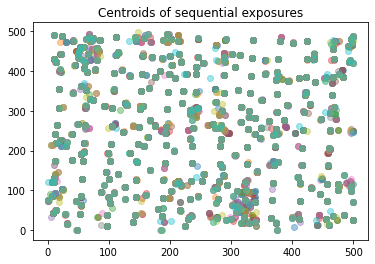

In [20]:
# Show issues with multiply detected sources which which we remedy with matching rejection
for i in range(ncats):
    xfoo,yfoo=cat_arr[i]['base_SdssCentroid_x'],cat_arr[i]['base_SdssCentroid_y']
    plt.plot(xfoo,yfoo,'o',alpha=.4)
plt.title('Centroids of sequential exposures')

The above image illustrates a problem with comparing images with different exposure times. Namely, that different sets of objects may be detected. To remedy this, we use a fiducial frame as reference and simply match the catalogs by looking for *single* object matches within a specified distance of those fiducial objects. We then collect a shape measurement (e.g. `base_SdssShape_xx/yy`) for that object as well as a brightness measurement (e.g. `base_SdssShape_flux`) to test for a trend in size vs. brightness.

In [21]:
fidframe=10 # frame number to compare to
maxdist=.5  # max distance to match objects between frames

# choose which stack measurements to use for centroids and shape
# +TODO use 'ext_shapeHSM_HsmSourceMoments_xx','ext_shapeHSM_HsmSourceMoments_yy'
cen_param1,cen_param2='base_SdssCentroid_x','base_SdssCentroid_y'
bf_param1,bf_param2='base_SdssShape_xx','base_SdssShape_yy'
flux_param='base_CircularApertureFlux_25_0_instFlux'#'base_CircularApertureFlux_25_0_Flux' #'base_GaussianFlux_flux' # or or 'base_SdssShape_flux'

# get the centroids (used for matching) from the fiducial frame 
x0s,y0s=cat_arr[fidframe][cen_param1],cat_arr[fidframe][cen_param2]
nspots=len(x0s)

# make an array to hold that number of objects and their centroid/shape/flux measurements
# the 8 rows collect x/y centroid, x/y shape, x/y corrected shape, flux, and corrected flux
bf_dat=np.empty((ncats,nspots),
                dtype=np.dtype([('x', float), ('y', float),('shapex', float), ('shapey', float),
                             ('corrshapex', float), ('corrshapey', float),
                             ('flux', float), ('corrflux', float)]))
bf_dat[:]=np.nan   # so that un-matched objects aren't plotted/used by default


# loop over catalogs
for i in range(ncats):
    # get the centroids of objects in the bf-corrected and uncorrected images
    x1,y1=cat_arr[i][cen_param1],cat_arr[i][cen_param2]
    x1_bf,y1_bf=bf_cat_arr[i][cen_param1],bf_cat_arr[i][cen_param2]
    # loop over fiducial frame centroids to find matches
    for j in range(nspots):   
        x0,y0=x0s[j],y0s[j] # fiducial centroid to match
        # find objects in both catalogs which are within maxdist
        bf_gd=np.where(np.sqrt((x1_bf-x0)**2+(y1_bf-y0)**2)<maxdist)[0]
        gd=np.where(np.sqrt((x1-x0)**2+(y1-y0)**2)<maxdist)[0]
        if (len(bf_gd)==1 & len(gd)==1):  # only take single matches
            xx,yy=cat_arr[i][bf_param1][gd],cat_arr[i][bf_param2][gd] # centroids
            xx_bf,yy_bf=bf_cat_arr[i][bf_param1][bf_gd],bf_cat_arr[i][bf_param2][bf_gd]  # sizes
            flux,flux_bf=cat_arr[i][flux_param][gd],bf_cat_arr[i][flux_param][bf_gd] # fluxes
            bf_dat[i,j]=x0,y0,xx,yy,xx_bf,yy_bf,flux,flux_bf  # keep those above measurements

## Plot the brighter-fatter effect on those shape measurements and the corrected version
Alongside stamps of each object, below we show the trend of X and Y sizes before and after brighter-fatter correction. By default this makes a dozen plots in as many seconds and saves them to the catalog directory.

In [22]:
np.arange(10,20)

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

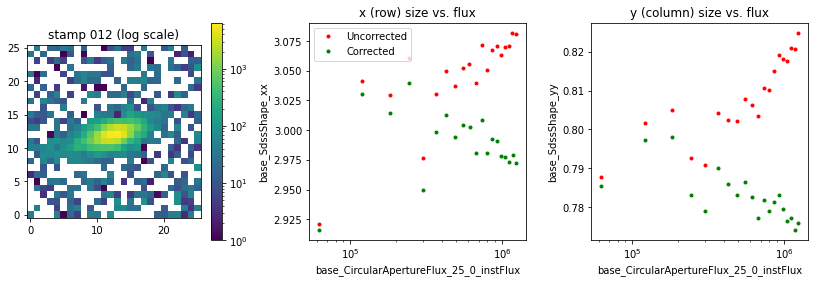

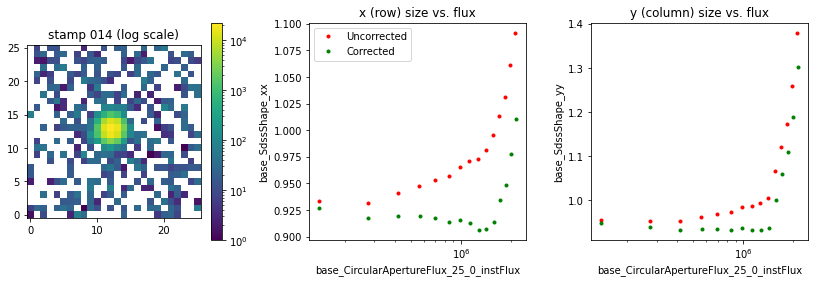

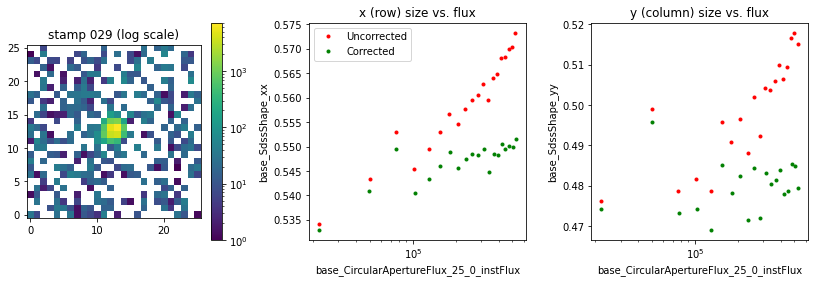

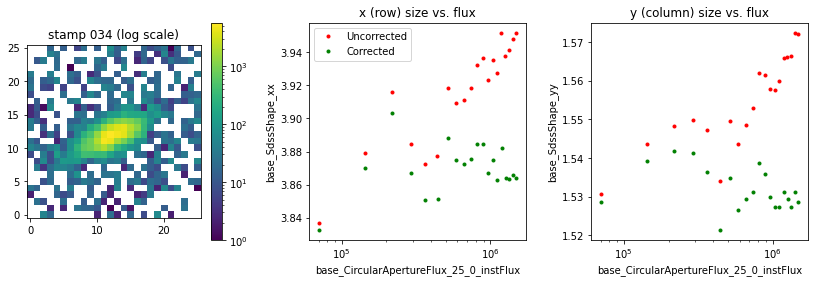

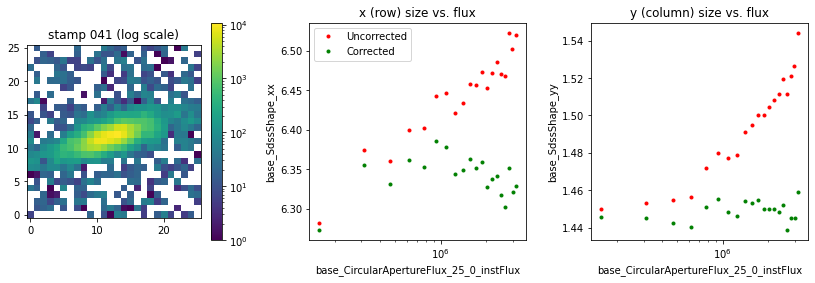

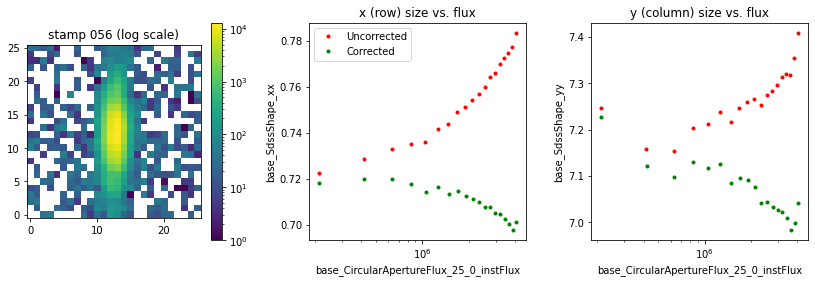

In [23]:
sz=13 # stamp size

# loop over some objects and save a summary figure
# [0,6,12,18,23,35,44,46,52,56,69,71,114] are good indices to look with default values 
# or e.g. np.random.choice(np.arange(nspots),size=10)
indexfoo=[12,14,29,34,41,56]

for index in indexfoo:
    plt.figure(figsize=(14,4)),plt.subplots_adjust(wspace=.3)
    
    # grab a postage stamp, integerizing the centroid and shipping
    # if it is near the edge, +TODO in a stackly manner
    xc,yc=bf_dat['x'][fidframe,index].astype('int')+1,bf_dat['y'][fidframe,index].astype('int')+1
    if ((np.abs(xc-250)>250 - sz ) | (np.abs(yc-250)>250 - sz )): continue
    stamp=exposure.getImage().array[yc-sz:yc+sz,xc-sz:xc+sz]
    
    # show the stamp with log scale (1,max)
    plt.subplot(131),plt.title('stamp '+str(index).zfill(3)+' (log scale)')
    plt.imshow(stamp,origin='lower',norm=LogNorm(1,stamp.max())),plt.colorbar()
    
    # x size vs flux
    plt.subplot(132),plt.title('x (row) size vs. flux')
    plt.plot(bf_dat['flux'][:,index],bf_dat['shapex'][:,index],'r.',label='Uncorrected')
    plt.plot(bf_dat['corrflux'][:,index],bf_dat['corrshapex'][:,index],'g.',label='Corrected')
    plt.xlabel(flux_param),plt.ylabel(bf_param1),plt.xscale('log')
    plt.legend(loc='upper left')

    # y size vs flux
    plt.subplot(133),plt.title('y (column) size vs. flux')
    plt.plot(bf_dat['flux'][:,index],bf_dat['shapey'][:,index],'r.',label='Uncorrected')
    plt.plot(bf_dat['corrflux'][:,index],bf_dat['corrshapey'][:,index],'g.',label='Corrected')
    plt.xlabel(flux_param),plt.ylabel(bf_param2)
    plt.xscale('log')
    plt.savefig(cat_dir+str(index).zfill(5)+'bfcorr.png')

The above figures illustrate the brighter-fatter effect (slight increasing size with flux) in the red dots, and the corrected image analysis in green. Curiously, some of the objects indicate that the default correction method is properly correcting star-like objects, but over- or under-correcting the effect in galaxy images. This could be due to a violation of some of the underlying assumptions in the method, including the small-pixel approximation or the linearity of kernel correction. Some of the remaining trends could be related to an increase in signal-to-noise in the images, however this is a universally applicable issue with shape measurement and is beyond the scope of this notebook. In some of the figures, a rapid increase in size can be seen at the highest fluxes, indicating saturation of pixel wells which is unrelated to the brighter-fatter effect.

Now plot the flux lost/gained in the process of brighter-fatter correction, by subtracting the flux of the corrected images from the uncorrected ones. The flux measurement is the same as the one used in the above figures and is measured in electrons.

Text(0, 0.5, 'Measured flux change due to correction \n (before - after) [%]')

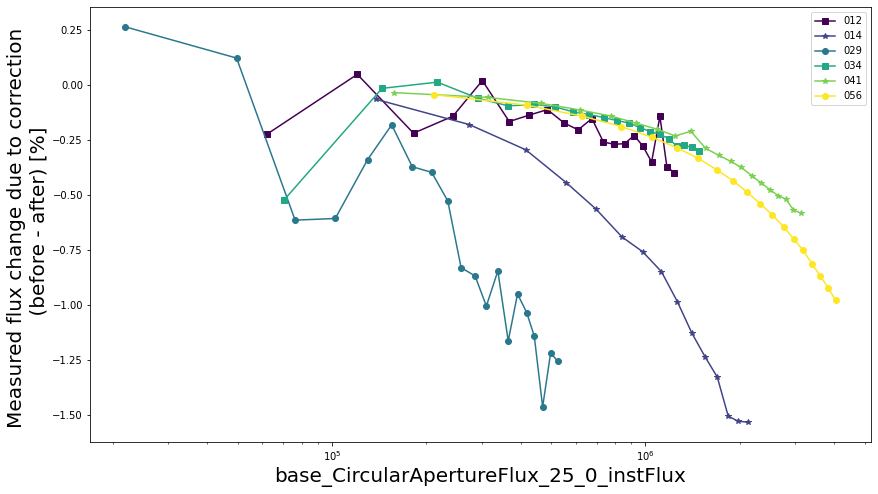

In [24]:
colorpalette=cycle(plt.cm.viridis(np.linspace(0,1,len(indexfoo))))
stylepalette=cycle(['s','*','o'])
plt.figure(figsize=(14,8))
for nfoo in indexfoo:
    flux_foo=bf_dat['flux'][:,nfoo]
    fluxdiffpct_foo=(bf_dat['flux'][:,nfoo]-bf_dat['corrflux'][:,nfoo])/bf_dat['flux'][:,nfoo]*100.
    plt.plot(flux_foo,fluxdiffpct_foo,label=str(nfoo).zfill(3),c=next(colorpalette),marker=next(stylepalette))
plt.xscale('log')#,plt.yscale('symlog')
plt.legend()
plt.xlabel(flux_param,fontsize=20)
plt.ylabel('Measured flux change due to correction \n (before - after) [%]',fontsize=20)
#plt.savefig(cat_dir+'BF_corr_flux_change.png',dpi=150)

In [25]:
# +TODO other ways of doing matching, catalog stacking